## train a basic LSTM model

<p><input type="checkbox", disabled, checked> 1. refactor the processing data code in a utils.py file</p>
<p><input type="checkbox", disabled, checked> 2. train a LSTM model</p>
<p><input type="checkbox", disabled> 2. train a ConvLSTM model</p>

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Dense, Flatten, Input
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import utils, regularizers
from tensorflow.keras.callbacks import TensorBoard, LearningRateScheduler
from tensorflow.keras import backend as K

from utils.data import load_capg_data, CapgDBName, LoadMode

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)  # set this TensorFlow session as the default session for Keras

In [2]:
# set const values
weights_file = './models/capg_convLSTM_weights.h5'
model_file = './models/capg_convLSTM_model.h5'
window_len = 50
BATCH_SIZE = 128
test_splite = 0.1

In [3]:
# load capg dba data
x_train, y_train, category = load_capg_data(CapgDBName.dba, LoadMode.sequence_frame)
seg_length = int(x_train.shape[1] / window_len)

x_train = x_train.reshape(x_train.shape[0]*seg_length, window_len, x_train.shape[2], x_train.shape[3], x_train.shape[4])
y_train = y_train.reshape(y_train.shape[0], 1) * np.ones((1, seg_length))
y_train = y_train.flatten()
y_train = utils.to_categorical(y_train - 1, category)

index = np.random.choice(x_train.shape[0], int(x_train.shape[0]*test_splite))
x_test = x_train[index]
y_test = y_train[index]

x_train = np.delete(x_train, index, axis=0)
y_train = np.delete(y_train, index, axis=0)

print('train set')
print(x_train.shape)
print(y_train.shape)
print('test set')
print(x_test.shape)
print(y_test.shape)

train set
(26060, 50, 16, 8, 1)
(26060, 8)
test set
(2880, 50, 16, 8, 1)
(2880, 8)


In [4]:
# inputs = Input(shape=(50, 16, 8, 1), name='input')
# x = ConvLSTM2D(filters=32, kernel_size=(3,3), input_shape=(128, 50, 16, 8, 1), padding='same', activation='relu',
#                activity_regularizer=regularizers.l1(l=0.01), name='convlstm_1')(inputs)

# x = Flatten(name='flat')(x)
# predictions = Dense(8, activation='softmax', name='output')(x)
# model = Model(inputs=inputs, outputs=predictions)

In [5]:
model = Sequential()
model.add(ConvLSTM2D(filters=32, kernel_size=(3,3), input_shape=(50, 16, 8, 1), padding='same',
                     activation='relu', activity_regularizer=regularizers.l1(l=0.01), name='convlstm_1'))
model.add(Flatten(name='flat'))
# model.add(BatchNormalization(momentum=0.9, name='bn_1'))
# model.add(Dense(256, activation='relu', name='dense_1'))
model.add(Dense(8, activation='softmax', name='output'))

if os.path.exists(model_file):
    print('load weights from a trained model')
    model.load_weights(model_file, by_name=True)
else:
    print('train a new model')

Instructions for updating:
Colocations handled automatically by placer.
train a new model


In [6]:
sgd = SGD(clipnorm=1, clipvalue=0.5, momentum=0.9)
# adam = Adam(epsilon=10e-8, clipnorm=1, clipvalue=0.5)
model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
convlstm_1 (ConvLSTM2D)      (None, 16, 8, 32)         38144     
_________________________________________________________________
flat (Flatten)               (None, 4096)              0         
_________________________________________________________________
output (Dense)               (None, 8)                 32776     
Total params: 70,920
Trainable params: 70,920
Non-trainable params: 0
_________________________________________________________________


In [7]:
# tb_callback = TensorBoard(log_dir='./logs/lstm/',
#                           histogram_freq=1,
#                           batch_size=32,
#                           write_grads=True,
#                           update_freq='batch')

In [8]:
def learning_rate_tuner(epoch):
    lr = 0.1
    if 16 <= epoch < 40:
        lr = 0.01
    elif epoch >= 40:
        lr = 0.001
    return lr

lr_scheduler = LearningRateScheduler(learning_rate_tuner)

In [9]:
history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=60,
                    validation_data=(x_test, y_test), callbacks=[lr_scheduler])

Train on 26060 samples, validate on 2880 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/60
26060/26060 [==============================] - 26s 1ms/sample - loss: 2.0816 - acc: 0.1239 - val_loss: 2.0816 - val_acc: 0.1243
Epoch 2/60
26060/26060 [==============================] - 25s 975us/sample - loss: 2.0809 - acc: 0.1255 - val_loss: 2.0736 - val_acc: 0.1358
Epoch 3/60
26060/26060 [==============================] - 25s 977us/sample - loss: 2.0661 - acc: 0.1284 - val_loss: 2.0608 - val_acc: 0.1323
Epoch 4/60
26060/26060 [==============================] - 25s 974us/sample - loss: 2.0641 - acc: 0.1305 - val_loss: 2.0603 - val_acc: 0.1330
Epoch 5/60
26060/26060 [==============================] - 25s 973us/sample - loss: 2.0626 - acc: 0.1398 - val_loss: 2.0619 - val_acc: 0.1351
Epoch 6/60
26060/26060 [==============================] - 25s 977us/sample - loss: 1.9601 - acc: 0.2282 - val_loss: 1.7773 - val_acc: 0.3542
Epoch 7/60
26060/26060 [==============================] - 2

26060/26060 [==============================] - 26s 981us/sample - loss: 1.2539 - acc: 0.6094 - val_loss: 1.2722 - val_acc: 0.5951
Epoch 57/60
26060/26060 [==============================] - 25s 974us/sample - loss: 1.2538 - acc: 0.6106 - val_loss: 1.2720 - val_acc: 0.5927
Epoch 58/60
26060/26060 [==============================] - 26s 982us/sample - loss: 1.2537 - acc: 0.6102 - val_loss: 1.2715 - val_acc: 0.5962
Epoch 59/60
26060/26060 [==============================] - 25s 978us/sample - loss: 1.2536 - acc: 0.6094 - val_loss: 1.2723 - val_acc: 0.5924
Epoch 60/60
26060/26060 [==============================] - 25s 973us/sample - loss: 1.2534 - acc: 0.6100 - val_loss: 1.2715 - val_acc: 0.5965


In [10]:
model.save_weights(weights_file)
model.save(model_file)
print(history.history.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


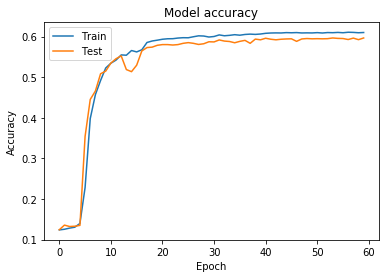

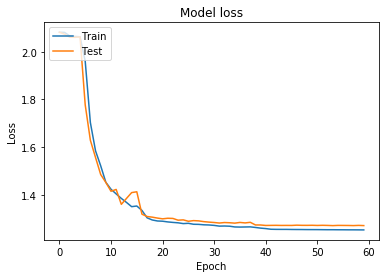

In [11]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./figures/convlstm_acc.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('./figures/convlstm_loss.png')
plt.show()

In [12]:
# DATA_DIR = '../data/capg_baseline/'
# data_files = os.listdir(DATA_DIR)

# data_x = np.empty((60800, 50, 8, 16, 3))
# data_y = np.zeros((60800, 8))
# i = 0
# for file_name in data_files:
#     if file_name.find('ab-') == -1:
#         continue
#     gesture_num = int(file_name[5:6])-1
#     h5f = h5py.File(os.path.join(DATA_DIR, file_name))
#     # 将数据切为50长度的片段
#     emg_data = h5f[file_name][:]
#     emg_data = emg_data.reshape((emg_data.shape[0]*20,
#                                  50,
#                                  emg_data.shape[2], 
#                                  emg_data.shape[3], 
#                                  emg_data.shape[4]))
#     data_x[7600*i:7600*(i+1)] = emg_data
#     data_y[7600*i:7600*(i+1), gesture_num] = 1
#     i += 1
# print(data_x.shape)
# print(data_y.shape)

In [13]:
# TODO: 
# 1. 先检查数据输入是否正确
# 2. 每个gesture抽样32000个sample进行训练

In [14]:
# x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.1, random_state=42)
# print(x_train.shape)
# print(y_train.shape)
# print()
# print(x_test.shape)
# print(y_test.shape)
# del data_x, data_y